<font color="#483D8B">
<h1  align="center">Credit Card Default Payment Analysis</h1>
<div align="center">
<font size=3><b>
<br>INET4710 Project 1
<br>Renard Klosowski, Markus Petterson , Erik Guterman
<br>Febuary 17th, 2020
<br></font></b></div>

<h1  align="center">Overview</h1>
<font size=3>

In [0]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from IPython.core.display import Image, display

import findspark
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession


In [0]:
spark = SparkSession.builder \
	.master("local[*]") \
	.appName("Learning_Spark") \
	.getOrCreate()

### Business Objective: 

Find out what type of customer is most likely to default on their payment along with what type of customer does make a payment on time and the differences between these customers. 



### Main Objective of this analysis

Which individuals are most likely to default on their payments? 
*   If we can identify individuals more likely to default, we can reach out with alternative methods such as payment plans. 
*   Customers defaulting on payments loses the lender money, so keeping them from defaulting earns the company more money. 
*   Additionally, customers unlikely to default can be given higher lines of credit

### Models created for this project

Ensemble methods will be used with classification algorithms

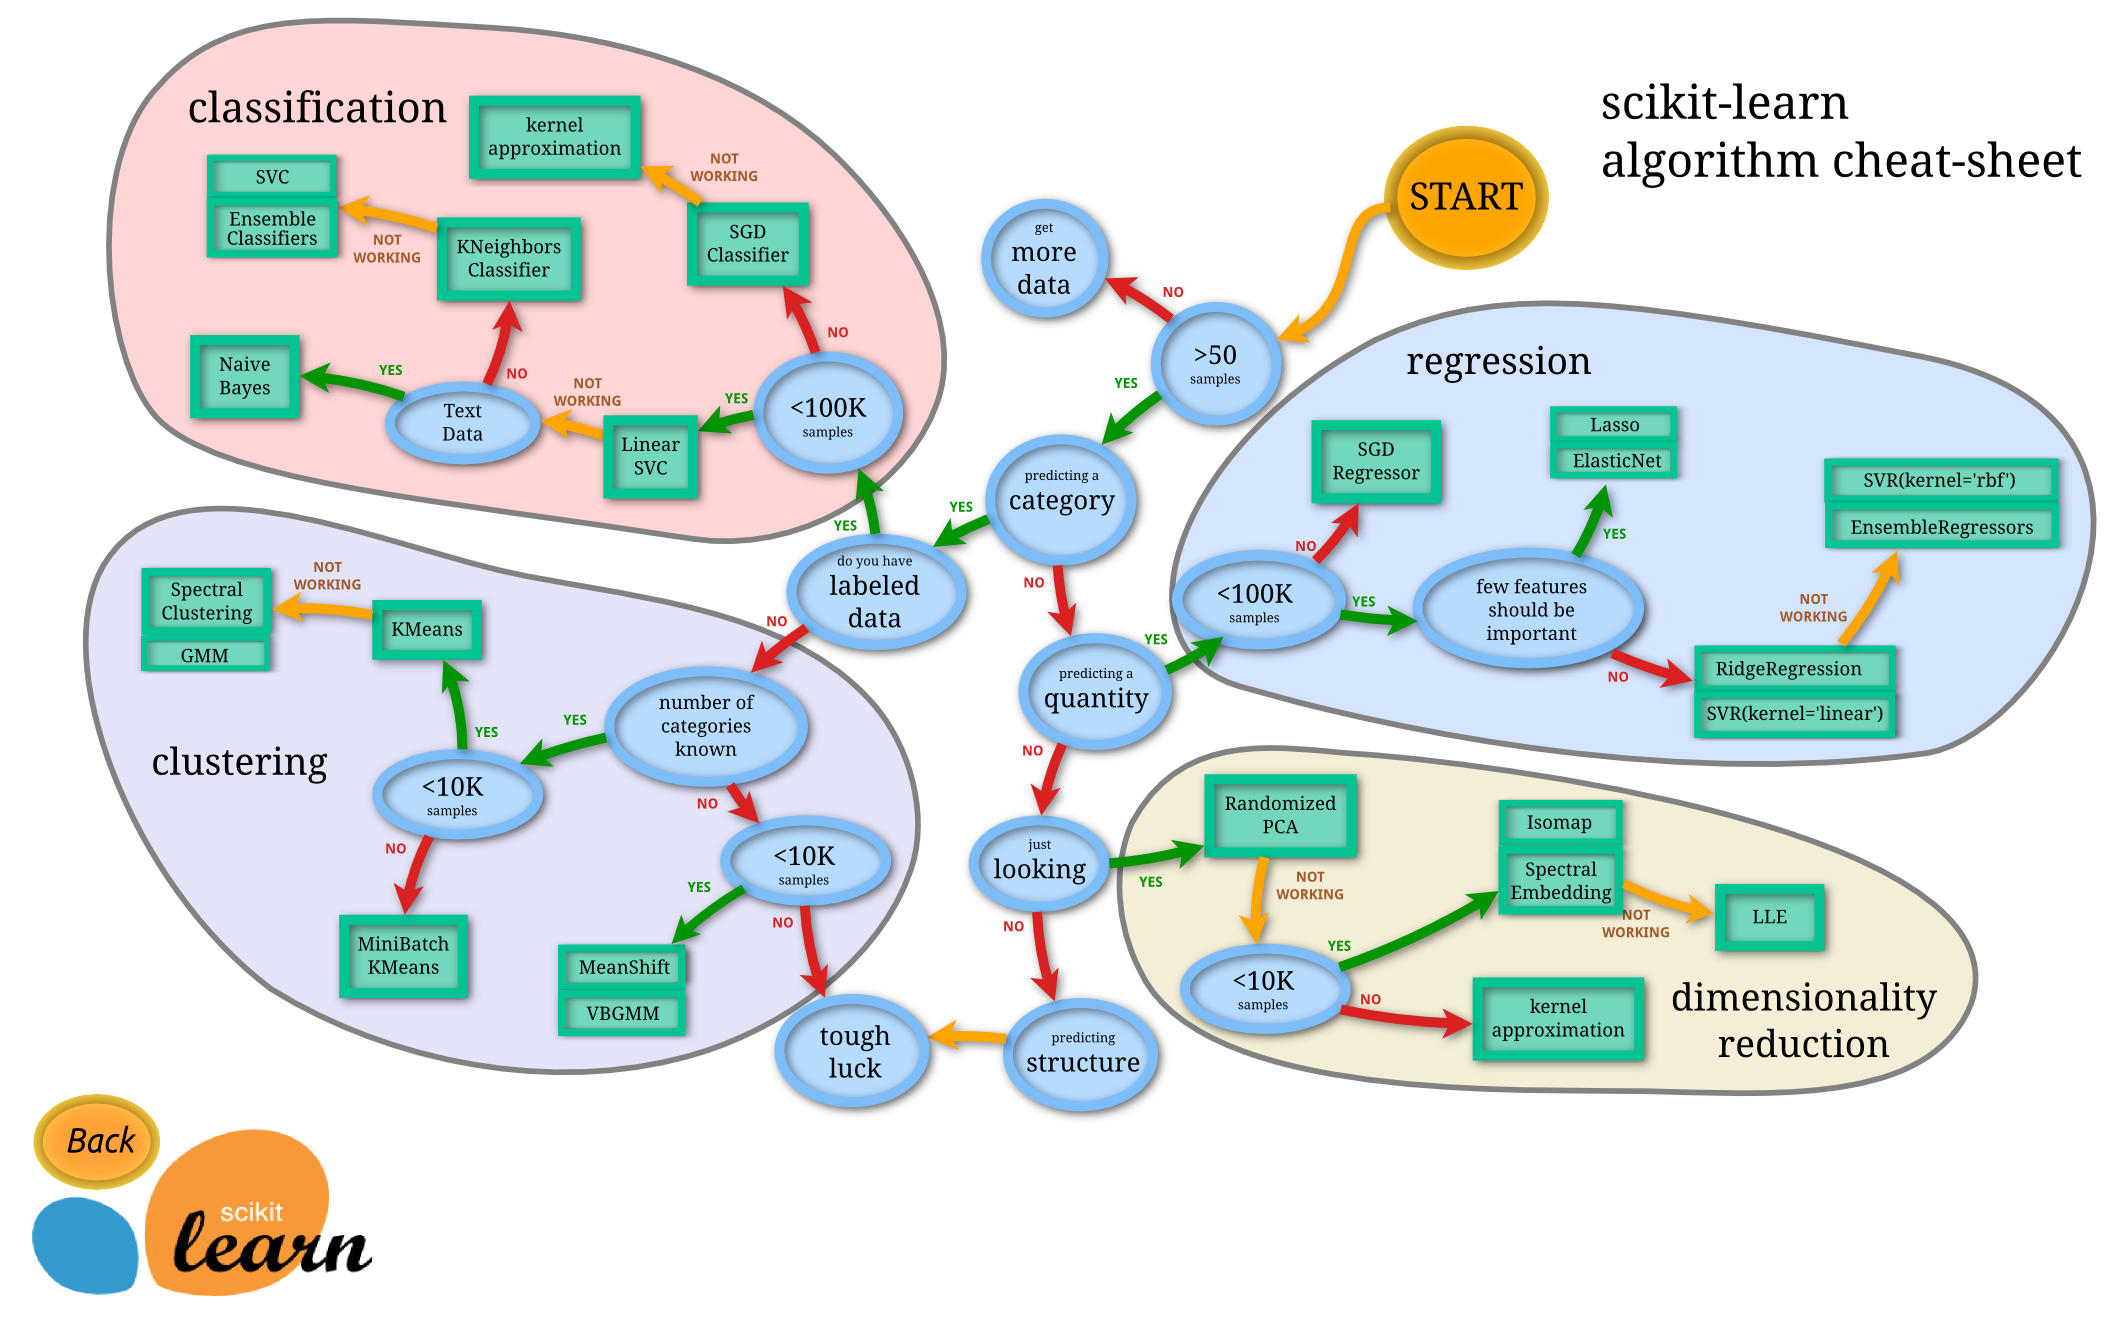

In [0]:
display(Image('https://scikit-learn.org/stable/_static/ml_map.png', width=900, unconfined=True))

### Description of dataset

This dataset is about information on people that default on their credit card payments. This informaiton includes demographics, social status, credit data, history of payments and monthly billing statements. This information is from credit card clients in Taiwan from April 2005 to September 2005.  

This dataset can be found on kaggle or from the source which is UCI machine learning repository https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

<h1  align="center">Exploratory Data Analysis</h1>
<font size=3>

In [0]:
#Loading in data
df2 = spark.read.csv('UCI_Credit_Card.csv',inferSchema=True, header=True)
df = pd.read_csv('UCI_Credit_Card.csv')

In [0]:
#Checking amount of rows and columns
df2.count(), len(df.columns)

(30000, 25)

In [0]:
#Checking the statistics of the data frame to see if data should be normalized
df2.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|               ID|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|             PAY_0|               PAY_2|             PAY_3|               PAY_4|             PAY_5|            PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|         BILL_AMT4|        BILL_AMT5|       BILL_AMT6|         PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|default.payment.next.month|
+-------+-----------------+---

In [0]:
df2.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default.payment.next.month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

Above we can see that the mean for most of a data has a large variation and we should do some normalizing of the data.

In [0]:
df2.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: decimal(7,0) (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: decimal(6,0) (nullable = true)
 |-- BILL_AMT2: decimal(6,0) (nullable = true)
 |-- BILL_AMT3: decimal(7,0) (nullable = true)
 |-- BILL_AMT4: decimal(6,0) (nullable = true)
 |-- BILL_AMT5: decimal(6,0) (nullable = true)
 |-- BILL_AMT6: decimal(6,0) (nullable = true)
 |-- PAY_AMT1: decimal(6,0) (nullable = true)
 |-- PAY_AMT2: decimal(7,0) (nullable = true)
 |-- PAY_AMT3: decimal(6,0) (nullable = true)
 |-- PAY_AMT4: decimal(6,0) (nullable = true)
 |-- PAY_AMT5: decimal(6,0) (nullable = true)
 |-- PAY_AMT6: dec

In [0]:
#Checking if target variable data is balanced
df['default.payment.next.month'].value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

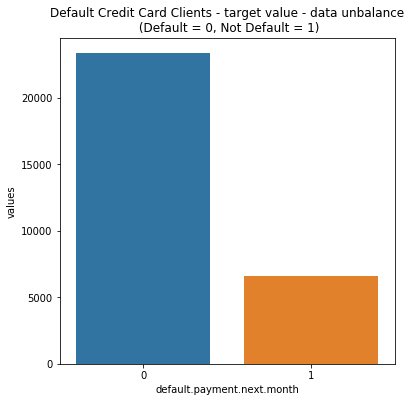

In [0]:
temp = df["default.payment.next.month"].value_counts()
df_2 = pd.DataFrame({'default.payment.next.month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default.payment.next.month', y="values", data=df_2)
locs, labels = plt.xticks()
plt.show()

Here we see that 23,364 customer maid their payments ontime in June and 6,636 did not. This means we should use some balancing technique such as SMOTE when training our data.

In [0]:
#Checking for NA's
df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

### Defining Variables

ID: Unique ID for each client
Provides a unique key, but little other information

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit  
Credit limit, watch for covariation here w/factors that make someone more creditworthy  

SEX: Binary variable for gender 
1 = Male, 2 = Female  

EDUCATION
1 = Graduate School, 2 = University, 3 = HS, 4 = Other, 5 & 6 = Unknown  

MARRIAGE: 
1 = Married, 2 = Single, 3 = Other
AGE: Age, in years  

For the following variables, 1 represents September 2005, and an increase of 1 represents one month prior to September 2005.  

PAY: Repayment status for the given month. 
-2 = no balance to pay, -1 = paid in full, 1 = payment late by one month, 2 = payment late by two months,….. 9 = payment late by nine months or more.  

BILL_AMT: Bill statement, in NT dollars, for the given month.  

PAY_AMT: Amount of previous payment, in NT dollars, for the given month.  

default.payment.next.month: Represents whether the given customer’s bill is expected to go into default within the next month. In June of 2005
Binary variable, 1 = Yes, 0 = No


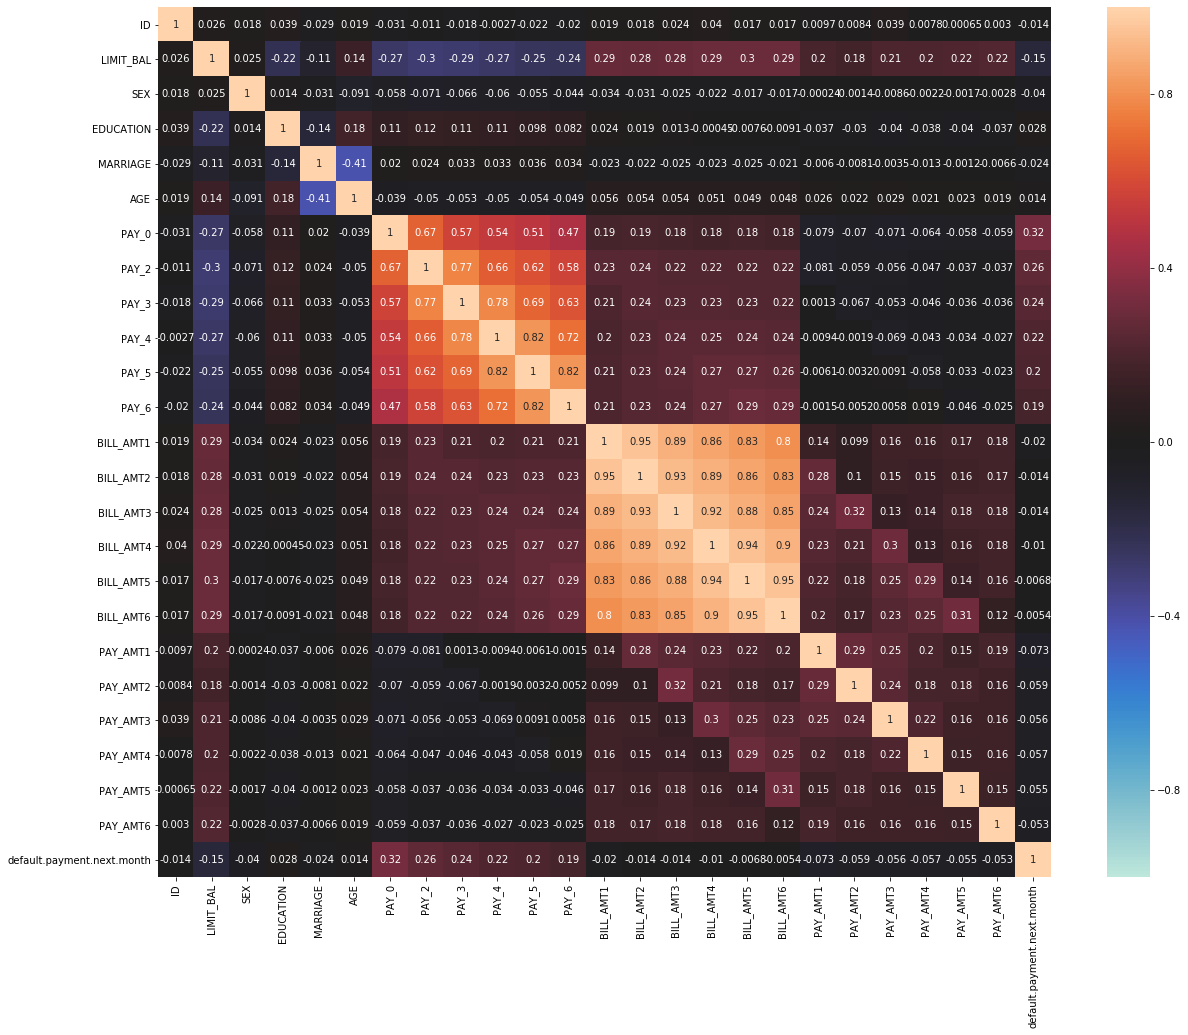

In [0]:
fig, ax = plt.subplots(figsize=(20,16))
corrmat = df.corr()
sns.heatmap(corrmat,-1,1,ax=ax,center=0,annot=True)

### Random Forest Classifier and Feature Importance

In [0]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [0]:
train_df, val_df = train_test_split(df, test_size=0.30, random_state=10)

In [0]:
clf = RandomForestClassifier(max_depth=2, random_state=10)

In [0]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [0]:
preds = clf.predict(val_df[predictors])

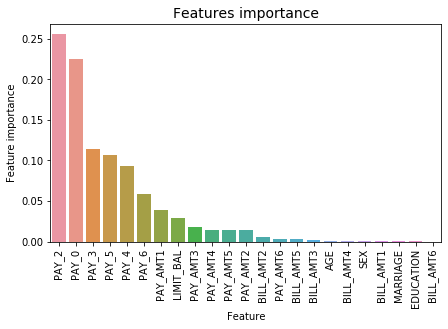

In [0]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   